# Линейная регрессия: переобучение и регуляризация

В данном ноутбуке рассматривается проблема переобучения линейных моделей. Разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(rc={'figure.figsize': (16, 10)})
%matplotlib inline
from matplotlib.axes._axes import _log
_log.setLevel('ERROR')

Рассматривается датасет `bikes_rent.csv`, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

## Знакомство с данными

Загрузим датасет с помощью функции `pandas.read_csv` в переменную `df`.

In [2]:
df = pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* `season`: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* `yr`: 0 - 2011, 1 - 2012
* `mnth`: от 1 до 12
* `holiday`: 0 - нет праздника, 1 - есть праздник
* `weekday`: от 0 до 6
* `workingday`: 0 - нерабочий день, 1 - рабочий день
* `weathersit`: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* `temp`: температура в Цельсиях
* `atemp`: температура по ощущениям в Цельсиях
* `hum`: влажность
* `windspeed(mph)`: скорость ветра в милях в час
* `windspeed(ms)`: скорость ветра в метрах в секунду
* `cnt`: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Рассмотрим на графиках, как целевой признак зависит от остальных.

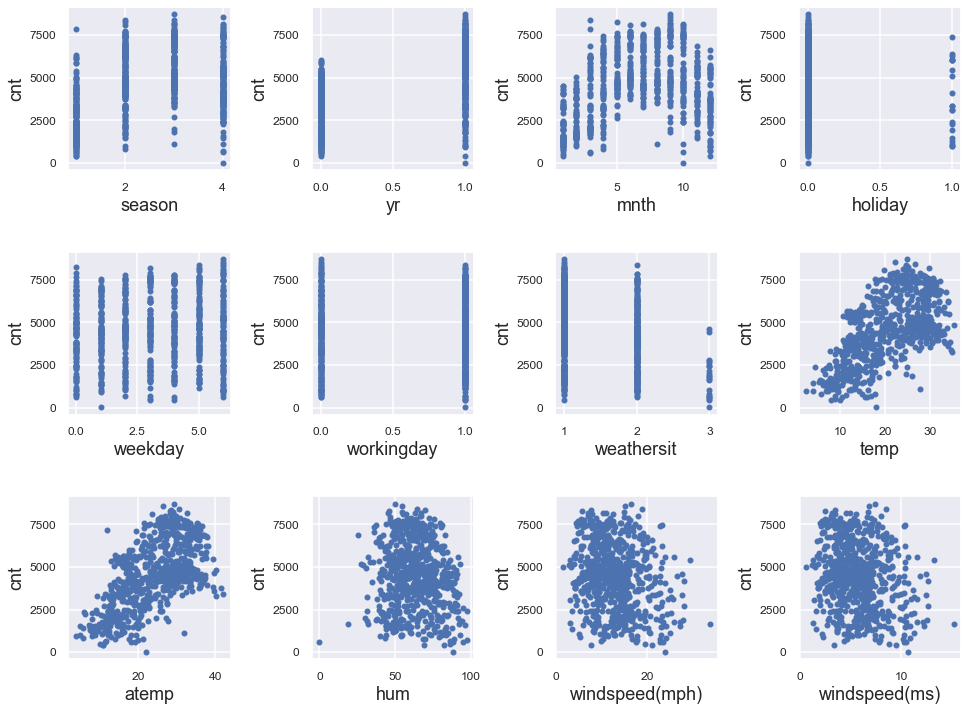

In [15]:
sns.set_context('talk')
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", 
            ax=axes[idx // 4, idx % 4], fontsize=12, grid=True);

- Начиная с мая минимальное и максимальное количество прокатов в месяц становится больше, чем за предыдущие месяца (с января по апрель включительно), но при приближении к ноябрю данная тенденция спадает, то есть максимальное и минимальное число прокатов уменьшается. В сентябре наблюдается самый высокий пик прокатов. В итоге можно сказать, что зависимость параболическая.
- По графикам видно, что сисло прокатов сильно коррелирует с признаками temp и atemp (однако один из них можно убрать), при этом почти линейно. Также линейная зависимость наблюдется между числом прокатов и годом, скорее всего это связанно с тем, что данная услуга стала более популярной.

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: `corr` и `corrwith`. Метод `df.corr` вычисляет матрицу корреляций всех признаков из датафрейма. Методу `df.corrwith` нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из `df` и этого датафрейма.

In [4]:
# Посчитаем корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:
df_corrw = df.loc[:, df.columns[:-1]].corrwith(df.cnt)
df_corrw

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому также посчитаем корреляции между вещественными признаками.

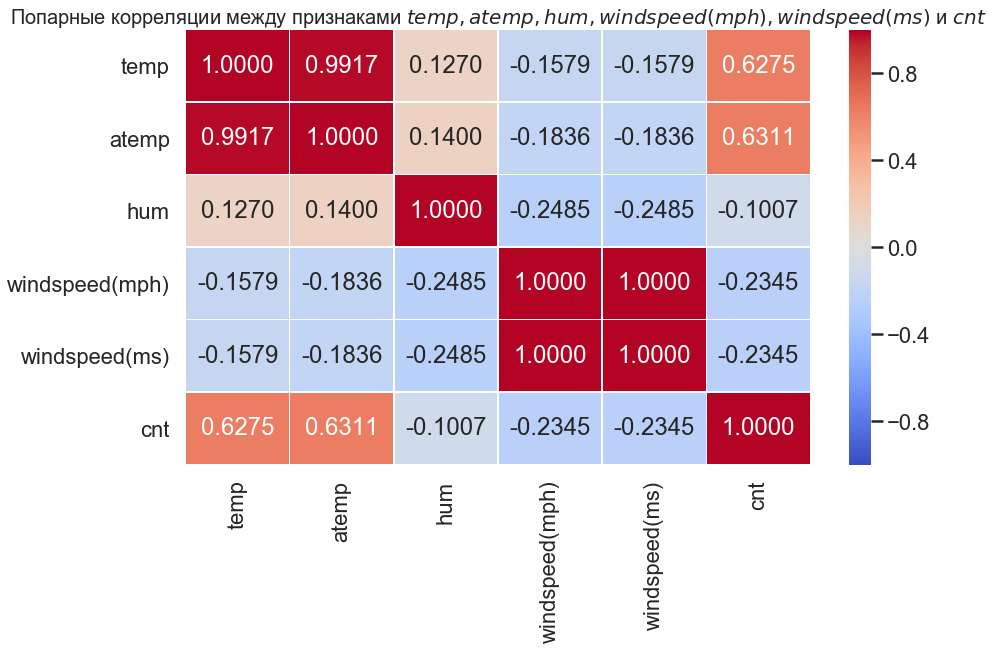

In [25]:
# Посчитаем попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
sns.set_context('poster')
columns = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']
fig, ax = plt.subplots(figsize=(14, 8)) 
sns.heatmap(df.corr().loc[columns, columns], annot=True, ax=ax,
            vmin=-1, vmax=1, fmt='.4f', linewidths=.5, cmap='coolwarm')
plt.title('Попарные корреляции между признаками $temp, atemp, hum, windspeed(mph), windspeed(ms)$ и $cnt$', 
          fontsize=20)
plt.show();

На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: `temp` и `atemp` (коррелируют по своей природе) и два `windspeed` (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод `mean`), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [26]:
# Cредние значения признаков
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

## Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [27]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [28]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [29]:
from sklearn.linear_model import LinearRegression

In [30]:
# Создадим объект линейного регрессора, обучим его на всех данных и выведем веса модели 
lr = LinearRegression().fit(X, y)
for feature, coef in zip(df.columns, lr.coef_):
    print('coef_' + feature + ' = ',  coef)

coef_season =  570.8675887934525
coef_yr =  1021.9652921309369
coef_mnth =  -141.30438378580345
coef_holiday =  -86.75613647415624
coef_weekday =  137.22482362623418
coef_workingday =  56.39056950314733
coef_weathersit =  -330.2332887484121
coef_temp =  367.47338726750786
coef_atemp =  585.5559979631937
coef_hum =  -145.6063153911189
coef_windspeed(mph) =  12458200269331.953
coef_windspeed(ms) =  -12458200269530.414


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют __проблемой мультиколлинеарности__.

С парой `temp-atemp` чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют $L1$ или $L2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется `Lasso`, а во втором `Ridge`.

Обучим регрессоры `Ridge` и `Lasso` с параметрами по умолчанию и убедимся, что проблема с весами решилась.

In [31]:
from sklearn.linear_model import Lasso, Ridge

In [32]:
# Обучим линейную модель с L1-регуляризацией и выведем веса
lasso = Lasso().fit(X, y)
for feature, coef in zip(df.columns, lasso.coef_):
    print('coef_' + feature + ' = ',  coef)

coef_season =  560.2416160308869
coef_yr =  1019.4634940657196
coef_mnth =  -128.73062703678752
coef_holiday =  -86.15278133371116
coef_weekday =  137.34789390496314
coef_workingday =  55.212370641356685
coef_weathersit =  -332.3698569623484
coef_temp =  376.3632362096995
coef_atemp =  576.5307935045503
coef_hum =  -144.1291550034858
coef_windspeed(mph) =  -197.13968940248557
coef_windspeed(ms) =  -2.8050167469807684e-08


In [33]:
# Обучим линейную модель с L2-регуляризацией и выведем веса
ridge = Ridge().fit(X, y)
for feature, coef in zip(df.columns, ridge.coef_):
    print('coef_' + feature + ' = ',  coef)

coef_season =  563.0645722520175
coef_yr =  1018.9483787875301
coef_mnth =  -131.873320282477
coef_holiday =  -86.74609799709219
coef_weekday =  138.0051111787191
coef_workingday =  55.90311037506478
coef_weathersit =  -332.34978849907395
coef_temp =  386.4578891919065
coef_atemp =  566.3470470600686
coef_hum =  -145.07132729867178
coef_windspeed(mph) =  -99.25944108179063
coef_windspeed(ms) =  -99.25944115434177


## Проблема вторая: неинформативные признаки

В отличие от $L2$-регуляризации, $L1$ обнуляет веса при некоторых признаках.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

In [34]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучим регрессор Lasso
# а затем обучим Ridge и запишем веса в coefs_ridge.
for i, alpha in enumerate(alphas):
    coefs_lasso[i] = Lasso(alpha=alpha).fit(X, y).coef_
    coefs_ridge[i] = Ridge(alpha=alpha).fit(X, y).coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

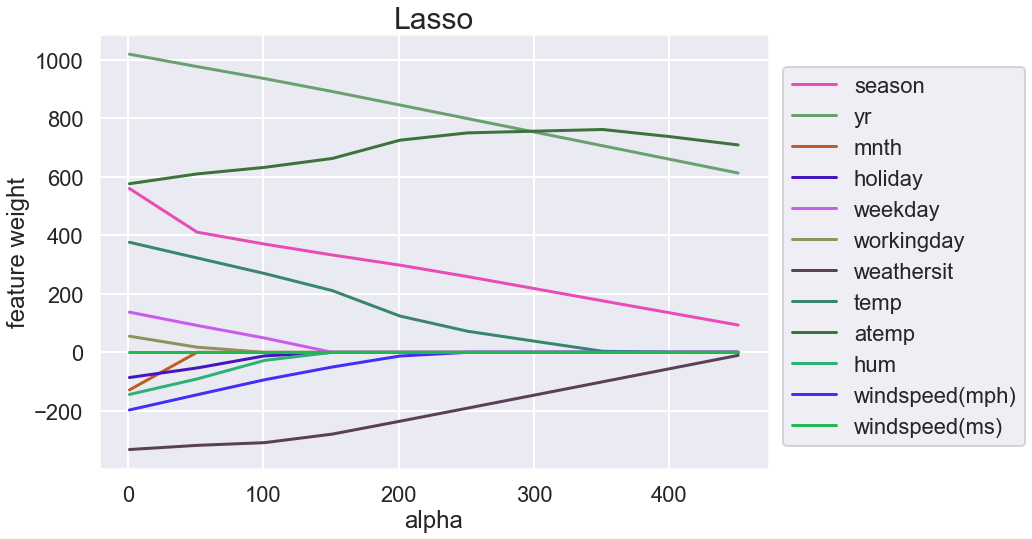

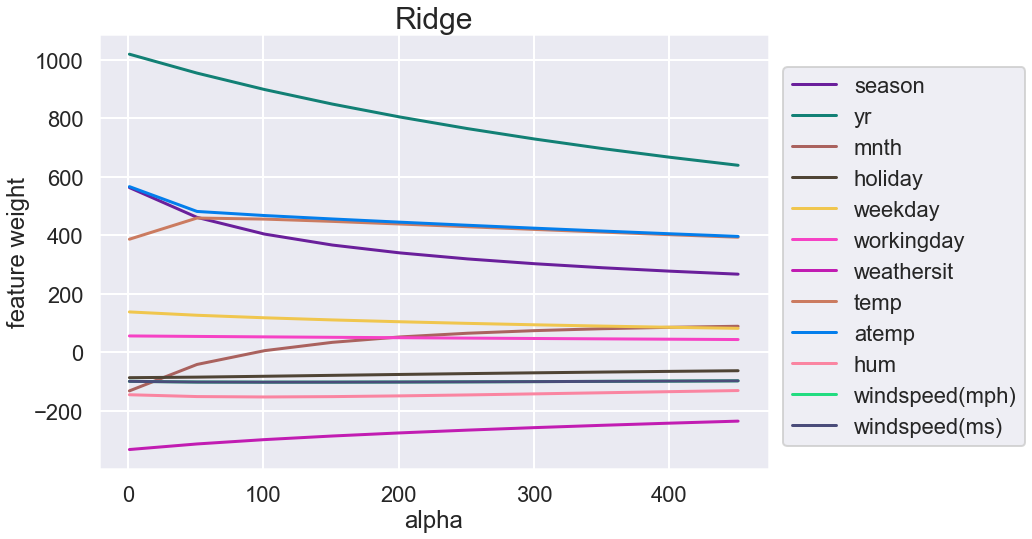

In [39]:
plt.figure(figsize=(12, 8))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso", fontsize=30)

plt.figure(figsize=(12, 8))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge", fontsize=30);

- Регуляризатор `Lasso` уменьшает веса сильнее, чем `Ridge`. Некоторые веса становятся в точности равны нулю.
- В конечном итоге все весса Lasso просто станут равные нулю, так как мы сильно штрафуем $L1$-норму весов.
- `Lasso` сразу же исключает один из признаков `windspeed`  при  $\alpha > 0$. `Ridge` при этом только уменьшает значение $L2$-нормы весов.
- Для отбора неинформативных признаков отлично подойдет `Lasso`.

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении $\alpha$ модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее $\alpha$. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать $\alpha$ по значению `MSE` на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется `holdout`), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения $\alpha$, а затем усреднять `MSE`. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в `sklearn` совсем просто: для этого есть специальный регрессор, `LassoCV`, который берет на вход список из $\alpha$ и для каждого из них вычисляет `MSE` на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __`mse_path_`__, матрицу размера `len(alpha) x k`, `k = 3` (число блоков в кросс-валидации), содержащую значения `MSE` на тесте для соответствующих запусков. Кроме того, в переменной __`alpha_`__ будет храниться выбранное значение параметра регуляризации, а в __`coef_`__, традиционно, обученные веса, соответствующие этому __`alpha_`__.

In [40]:
from sklearn.linear_model import LassoCV

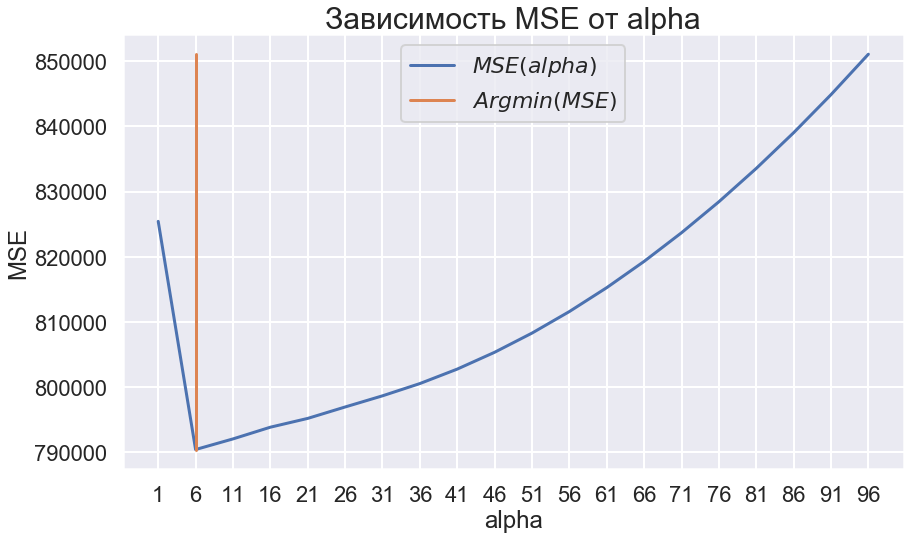

In [43]:
# Обучим регрессор LassoCV на всех параметрах регуляризации из alpha
# Построим график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)
LCV = LassoCV(alphas=alphas, cv=3).fit(X, y)
means = np.mean(LCV.mse_path_, axis=1)
alphas = LCV.alphas_
plt.figure(figsize=(14, 8))
plt.plot(alphas, means)
plt.xlabel("alpha")
plt.xticks(np.arange(min(alphas), max(alphas)+1, 5.0))
plt.ylabel("MSE")
plt.title("Зависимость MSE от alpha", fontsize=30);
plt.plot([alphas[means.argmin()]]*2, [means.min(), means.max()])
plt.legend(labels = ['$MSE(alpha)$', '$Argmin(MSE)$'], loc="upper center");

In [44]:
print('Optimum Alpha = ' + str(LCV.alpha_) + '\n')
for feature, coef in zip(df.columns, LCV.coef_):
    print('coef_' + feature + ' = ',  coef)

Optimum Alpha = 6

coef_season =  532.018982841354
coef_yr =  1015.0602226430597
coef_mnth =  -100.03952614356668
coef_holiday =  -83.2939598752991
coef_weekday =  132.50446549095787
coef_workingday =  51.55708561407389
coef_weathersit =  -330.5598567399812
coef_temp =  370.6798550300362
coef_atemp =  581.3969310654958
coef_hum =  -140.00740550068878
coef_windspeed(mph) =  -191.77140847135155
coef_windspeed(ms) =  -2.6853782866626636e-08


Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали `alpha`, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории `MSE`, соответствующие отдельным блокам выборки.

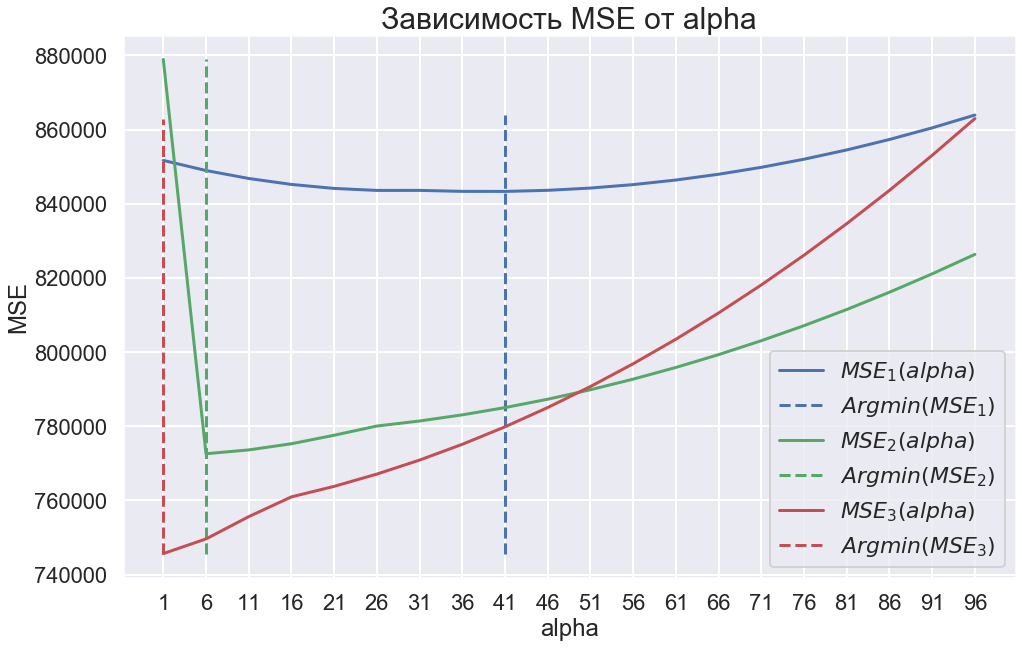

In [46]:
# Выведем значения alpha, соответствующее минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируем столбцы .mse_path_

alphas = LCV.alphas_
plt.figure(figsize=(16, 10))
for row_num, color in zip(range(3), ['b', 'g', 'r']):
    row = LCV.mse_path_[:, row_num]
    plt.plot(alphas, row, color=color)
    plt.plot([alphas[row.argmin()]]*2, [LCV.mse_path_.min(), row.max()],
             'r--', color=color)

plt.xlabel("alpha")
plt.xticks(np.arange(min(alphas), max(alphas)+1, 5.0))
plt.ylabel("MSE")
plt.title("Зависимость MSE от alpha", fontsize=30);
plt.legend(labels = ['$MSE_1(alpha)$', '$Argmin(MSE_1)$', 
                     '$MSE_2(alpha)$', '$Argmin(MSE_2)$',
                     '$MSE_3(alpha)$', '$Argmin(MSE_3)$'], loc="lower right");

На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое `MSE` на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

In [47]:
feature_coefs = {column: coef for (column, coef) in zip(df.columns, LCV.coef_)}
feature_coefs_sort = {column: coef for column, coef in sorted(feature_coefs.items(), key=lambda item: item[1])}
max_coef_col = list(feature_coefs_sort.keys())[-4:]

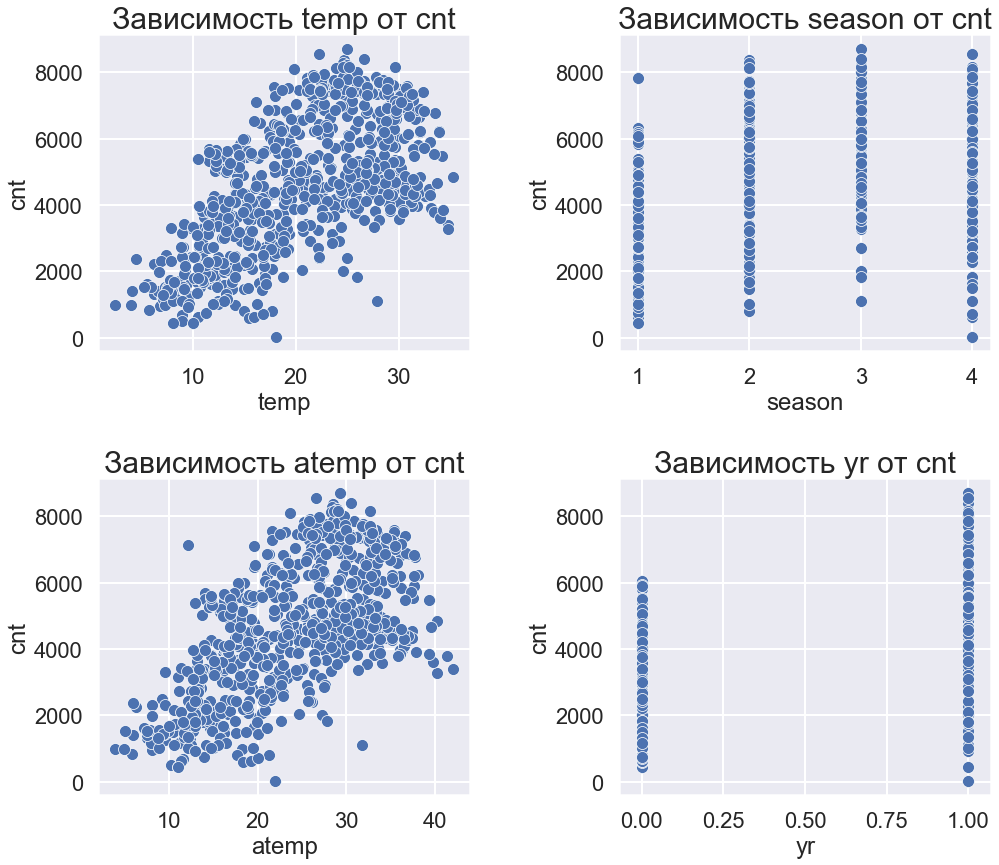

In [50]:
f, axes = plt.subplots(2, 2, figsize=(16, 14), sharex=False)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
for i, col_name in enumerate(max_coef_col):
    col = df[col_name]
    sns.scatterplot(col, y,  ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title('Зависимость ' + col_name + ' от cnt', 
                              fontsize=30)

- Возрастающая линейная зависимость действительно видна по графикам. Нельзя утверждать, что чем больше значения этих признаков, тем больше возьмут велосипеды. Так, например, при температуре 30 и выше, люди менее охотно берут велосипеды и, скорее всего, распределение скорее имеет вид перевернутой параболы с максимум при температуре 30 градусов. Season может принимать только 4 фиксированных значения, поэтому увеличивать его нельзя. Если увеличивать yr - это будет означать, что у нас будут данные за 2013 и так далее года. Возможно, что велосипеды будут брать чаще из-за распространения сервиса, но точно утверждать это нельзя.


In [51]:
min_coef_col = list(feature_coefs_sort.keys())[:3]

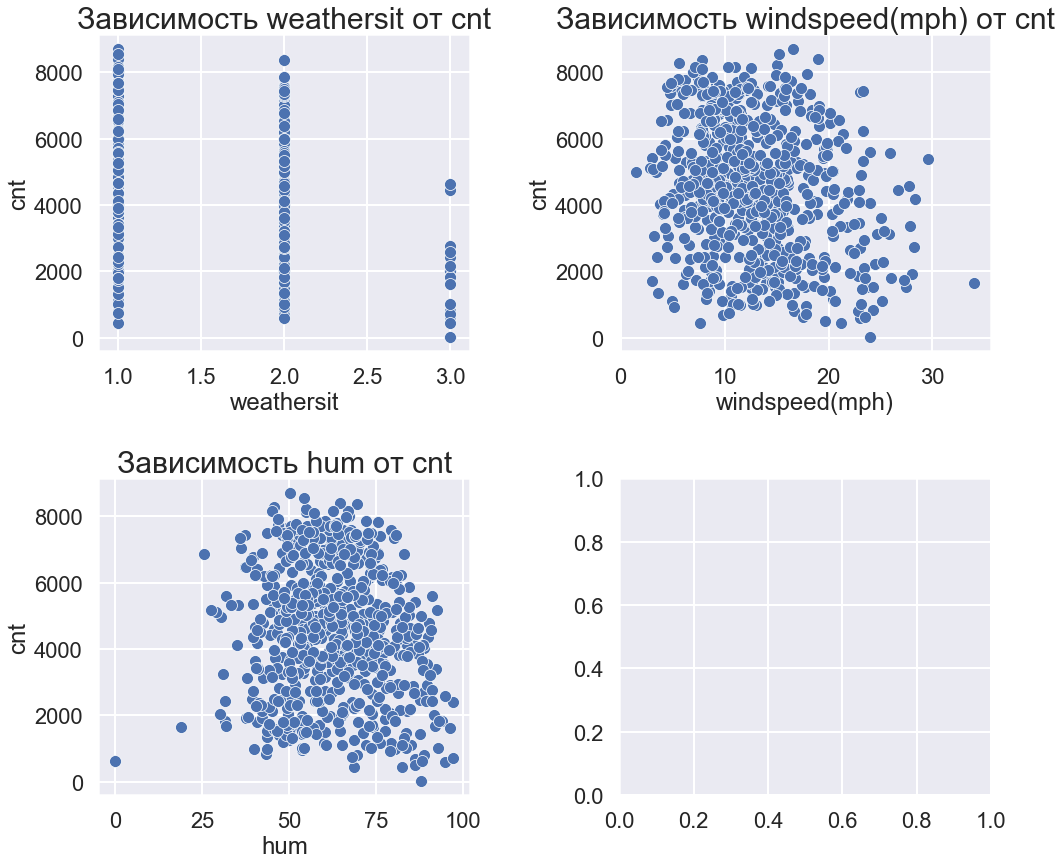

In [53]:
f, axes = plt.subplots(2, 2, figsize=(16, 14), sharex=False)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
for i, col_name in enumerate(min_coef_col):
    col = df[col_name]
    sns.scatterplot(col, y,  ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title('Зависимость ' + col_name + ' от cnt', 
                              fontsize=30)

- Убывающая зависимость действительно присутствует, но не так явно. При ухудшении погоды люди меньше берут велосипеды. Однако со скоростью ветра и влажностью не все так очевидно. Слишком большой разброс.

In [54]:
values = np.array(list(feature_coefs_sort.values()))
close_to_zero = list(feature_coefs_sort.keys())\
                [np.where(np.abs(values) < 1e-3)[0][0]]

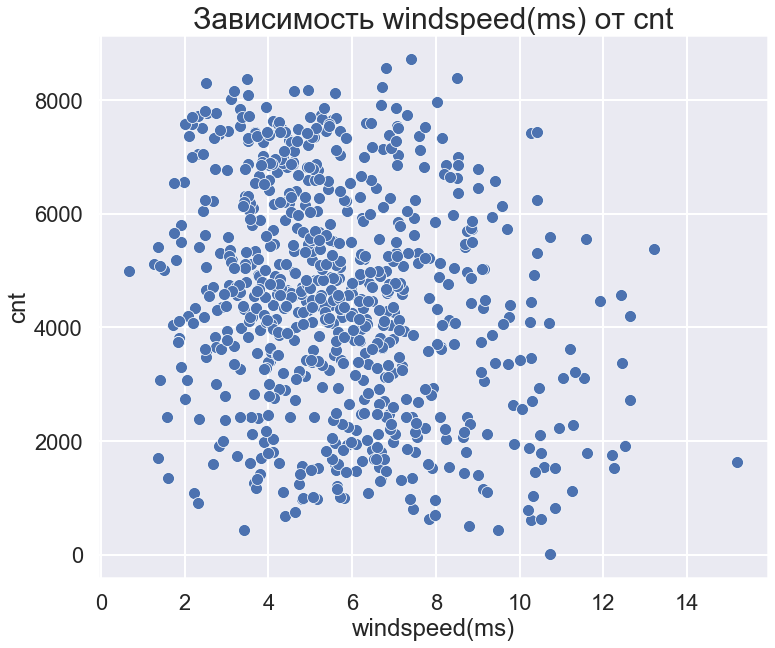

In [56]:
col = df[close_to_zero]
plt.figure(figsize=(12, 10))
sns.scatterplot(col, y)
plt.title("Зависимость " + close_to_zero + " от cnt", fontsize=30);

- Модель удалила данный признак, потому что он линейно зависим от другого и поэтому информация избыточная.

## Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.